<a href="https://colab.research.google.com/github/sid-betalol/CS6910-FODL-Assignment1/blob/main/cs6910_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**wandb setup**

In [3]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0648854d402ca2741ed41e05772e039c08aaaae68e6c514123e5da927ff925a3
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

###**Importing the required libraries and dataset**


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#**Getting and exploring the data**

In [6]:
from keras.datasets import fashion_mnist
np.random.seed(42)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [9]:
print('Train Data:')
print('X:', x_train.shape)
print('Y:', y_train.shape)
print()
print('Test Data:')
print('X:', x_test.shape)
print('Y:', y_test.shape)

Train Data:
X: (60000, 28, 28)
Y: (60000,)

Test Data:
X: (10000, 28, 28)
Y: (10000,)


###**Classwise Sample from data**

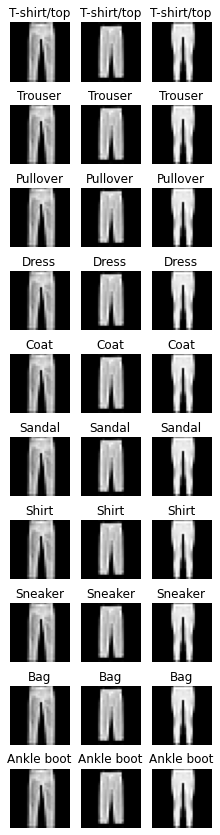

In [16]:
# y_train is used instead of y_test, as training data is expected
# to have samples from every class unlike the test data
num_labels = np.unique(y_train).shape[0]
# print(num_labels) ## prints 10 in accordance with the keras dataset
labels = [
    'T-shirt/top', 
    'Trouser', 
    'Pullover', 
    'Dress', 
    'Coat', 
    'Sandal', 
    'Shirt', 
    'Sneaker', 
    'Bag', 
    'Ankle boot',
    ]
def show_samples(n, X = x_train, Y = y_train, n_classes = num_labels, classes = labels):
    # n : number of samples to be shown from each class
    
    # samples divided by class
    labelled_data = {i: x_train[y_train==1] for i in range(n_classes)}
    
    # maximum number of available samples in each class  
    max_samples = {i:len(labelled_data[i]) for i in range(n_classes)}
    
    # maximum number of avilable samples will be shown if the user 
    # asks for more samples than avilable to be shown
    num_samples = {i: min(max_samples[i], n) for i in range(n_classes)}

    fig, axs = plt.subplots(nrows = 10, ncols = max(num_samples.values()), figsize=(1.2*max(num_samples.values()), 15))
    for i in range(10):
        for j in range(num_samples[i]):
            img = labelled_data[i][j].astype(np.uint8).reshape(28, 28)
            axs[i, j].imshow(img, cmap="gray")
            axs[i, j].axis("off")
            axs[i, j].set_title(classes[i])
    plt.show()

show_samples(3)